<img src="https://media.giphy.com/media/wG4p10gt7UqmOzGkMe/giphy.gif">

Netflix is one of the fastest growing OTT platforms in the world today. It has acquired a big viewer base of movie and TV show lovers across the globe especially in the last decade. It is rather exciting to make use of data science techniques to gather insights about this entertainment giant.

The netflix dataset consists of TV shows and Movies available on Netflix as of 2019. There are 6234 rows, one row for each show and 12 columns listing the attributes as mentioned below. The data fields are as follows:
* show_id: a unique id for each  show
* type: Type of content - either movie or tv show
* title: Title of the movie/tv show
* director: Director of the movie/tv show
* cast: Actors in the movie/tv show
* country: Country where the show is available
* date_added: Date when the show was added on Netflix
* release_year: Year of release of the movie/tv show
* rating: TV/Movie rating for the show
* duration: Duration of movie (in minutes)/tv show (in seasons)
* listed_in: Category in which the show is listed
* description: A brief description of the plot

As already mentioned, this data offers scope for doing some interesting analysis on movies and tv shows on Netflix and this would be my major focus in this notebook. To make this more interesting, I would integrate this dataset with IMDB ratings to carry out rating related analysis. I will also build a simple movie recommender system using NLP to get 10 movie recommendations based on a selected movie. This notebook contains
1. Loading the necessary packages and dataset
2. Exploratory Data Analysis
3. Data Cleaning & Preparation
4. Building a Basic Recommender system
5. Testing the system
6. Conclusion


# Import necessary packages

In [ ]:
#basic packages 
import numpy as np
import pandas as pd

#for plotting graphs
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set(font_scale=1.2)
import plotly.express as px
from plotly import graph_objects as go

#plot wordcloud
from collections import Counter
from wordcloud import WordCloud

#sklearn NLP tools
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import  cosine_similarity

#silence warnings
import warnings
warnings.filterwarnings('ignore')

# Load data

In [ ]:
all_data = pd.read_csv('../input/netflix-shows/netflix_titles.csv')

In [ ]:
#display top few rows
all_data.head()

In [ ]:
all_data.info()

# Exploratory Data Analysis

# 1. Netflix content type

In [ ]:
labels = all_data.type.value_counts().index
vals = all_data.type.value_counts().values
plt.pie(vals, explode=[0, 0.08], radius=1.6, labels=labels, autopct='%.1f', textprops={'fontsize': 14})
plt.title('Proportion of Movies & TV Shows', fontsize=14, fontfamily='calibri', fontweight='bold', position=(0.20, 1.22+0.02))
plt.show()

More than two-thirds of the content on Netflix consists of Movies

# 2. When was the content added during the observation period: 2008 - 2020?

In [ ]:
#create year column and parse year from date_added column
all_data['year'] = all_data['date_added'].dropna().apply(lambda x: x.split(',')[-1])

#parse month from date_added column
all_data['month'] = all_data['date_added'].dropna().apply(lambda x: x.lstrip().split(' ')[0])
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', \
               'September', 'October', 'November', 'December'][::-1]

In [ ]:
month_count = all_data.groupby('year')['month'].value_counts().unstack().fillna(0)[month_order].T

plt.figure(figsize=(10, 7), dpi=150)

# plot heatmap of content addition
plt.pcolormesh(month_count, cmap='gist_heat_r', edgecolors='white', linewidths=2) 
plt.xticks(np.arange(0.5, len(month_count.columns), 1), month_count.columns, fontsize=7, fontfamily='serif')
plt.yticks(np.arange(0.5, len(month_count.index), 1), month_count.index, fontsize=7, fontfamily='serif')
plt.title('Netflix Content Addition', fontsize=12, fontfamily='calibri', fontweight='bold', position=(0.20, 1.0+0.02))
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=8) 
cbar.ax.minorticks_on()
plt.show()

Most of the content is added in the year 2019. Also in terms of months, it appears that maximum content is added towards the year end. 

# 3. Growth trend

In [ ]:
all_data['date_added'] = pd.to_datetime(all_data['date_added'])

In [ ]:
movies = all_data[all_data['type']=='Movie']
tv_shows = all_data[all_data['type']=='TV Show']
year_added = pd.DataFrame(index=np.unique(all_data.date_added.dt.year))
mov = movies['date_added'].dt.year.value_counts()
tv = tv_shows['date_added'].dt.year.value_counts()
year_added['Movie'] = mov
year_added['TV_show'] = tv 
year_added = year_added.fillna(0).astype(int)

plt.figure(figsize=(10,6), dpi=110)
plt.plot(year_added.index, year_added.Movie, 'go-', label='Movie')
plt.plot(year_added.index, year_added.TV_show, 'ro-', label='TV Show')
plt.title('Content growth over the years', fontweight='bold')
plt.legend()
plt.show()

Over the years, more Movies have been added in Netflix than TV shows. The peak for both these types of content was in 2019 - about 1550 for Movies and 800 for TV Shows. Growth of content on the platform started picking up rapidly from 2015. 

# 4. Movie & TV Show rating analysis

**Movies with highest & lowest IMDB ratings**

As IMDB ratings are not readily available in netflix dataset, I'll be merging two separate IMDB datasets in order to get the ratings for the movies listed in netflix. 

In [ ]:
imdb_movies = pd.read_csv('../input/imdb-movie-ratings/IMDb movies.csv', usecols=['title','genre'])
imdb_ratings = pd.read_csv('../input/imdb-movie-ratings/IMDb ratings.csv', usecols=['weighted_average_vote'])

In [ ]:
ratings = pd.DataFrame({'title':imdb_movies.title, 'genre':imdb_movies.genre, \
                       'imdb_rating':imdb_ratings.weighted_average_vote})
ratings.drop_duplicates(subset=['title', 'imdb_rating'], inplace=True)
ratings.dropna()

# merging the ratings table with all_data table using inner join to drop any movies present in netflix table 
# but not in imdb ratings table
netflix_ratings = ratings.merge(all_data, left_on='title', right_on='title', how='inner')
netflix_ratings = netflix_ratings.sort_values(by='imdb_rating', ascending=False).dropna()

In [ ]:
top_rated=netflix_ratings[0:10]

# Plotly suburst plot showing release_year, released countries & title
fig =px.sunburst(
    top_rated,
    path=['release_year', 'country', 'title'],
    values='imdb_rating',
    color='imdb_rating', title='Movies with high ratings')
fig.show()

**Which are the low rated movies?**

In [ ]:
lowest_rated=netflix_ratings[-10:]
fig =px.sunburst(
    lowest_rated,
    path=['release_year', 'country', 'title'],
    values='imdb_rating',
    color='imdb_rating', title='Movies with low ratings')
fig.show()

Among the movies with high ratings, there are a couple of movies which released in 1970's. Let's see which are the oldest movies & TV shows available on Netflix

**Some oldest movies**

In [ ]:
movies[['title', 'release_year']].sort_values(by='release_year').head(15)

**Some oldest TV Shows**

In [ ]:
tv_shows[['title', 'release_year']].sort_values(by='release_year').head(15)

Besides the IMDB ratings, there are general TV show and film rating systems.

Television rating systems are meant to evaluate the content and report the suitability of television programs for children, teenagers, or adults. Many countries have their own television rating system and countries' rating processes vary by local priorities. Some of the ratings are: 
* TV-MA: These programs are intended to be viewed by mature, adult audiences and may be unsuitable for children under 17
* TV-14; This program may be unsuitable for children under 14 years of age
* TV-G: This program is suitable for all ages
and so on.

Similarly for movies:

* PG-13: Some material may be inappropriate for children under 13
* NC-17: Adults only etc

In [ ]:
rating_content_type = all_data[['type', 'rating']]
plt.figure(figsize=(12,7))
sns.countplot(rating_content_type['rating'], hue=rating_content_type['type'])
plt.xticks(rotation=45)
plt.title('Count of ratings by content type', fontsize=14, fontweight='bold', fontfamily='calibri')
plt.legend(loc='upper right')
plt.show()

# 5. Duration of movies and TV Shows

In [ ]:
movies_duration = movies.duration.apply(lambda x: x.split()[0])
plt.figure(figsize=(12,6))
sns.distplot(movies_duration)
plt.title('Distribution of duration of Movies in minutes')
plt.show()

**Count of TV Shows by number of seasons**

In [ ]:
season_order = ['1 Season', '2 Seasons', '3 Seasons', '4 Seasons', '5 Seasons', \
                                         '6 Seasons', '7 Seasons', '8 Seasons', '9 Seasons', '10 Seasons', \
                                         '11 Seasons', '12 Seasons', '13 Seasons', '14 Seasons', '15 Seasons']
plt.figure(figsize=(12,6))
sns.countplot(tv_shows.duration, order = season_order).set_title('Most frequent no. of seasons')
plt.xticks(rotation=90)
plt.show()

In [ ]:
duration = tv_shows['duration'].apply(lambda x: x.split()[0]).astype(int)
tv_shows['no_of_seasons'] = duration
most_seasons = tv_shows[['title', 'no_of_seasons']].sort_values(by='no_of_seasons', ascending=False)[:25]
plt.figure(figsize=(16,8))
sns.barplot(x = 'title', y='no_of_seasons', data=most_seasons).set_title('Shows with most seasons')
plt.xticks(rotation=90)
plt.show()

# 6. Which countries have a high share of contribution in terms of Content?

In [ ]:
# get the top 10 countries by overall content
top_countries = all_data['country'].value_counts() 
top_countries = pd.DataFrame(top_countries)
top10_countries = top_countries[:10].reset_index()

# creating a new dataframe which has country names in descending order of movies 
mov_vals = pd.DataFrame(movies['country'].value_counts()).reset_index()

# merging the mov_vals dataframe with top10_countries dataframe on country names and renaming columns
top10_countries=top10_countries.merge(mov_vals, left_on='index', right_on='index', \
                                      how='inner').rename(columns={"country_x":"Overall", "country_y":"Movies"})

# creating a new dataframe which has country names in descending order of TV shows 
tv_vals = pd.DataFrame(tv_shows['country'].value_counts()).reset_index()

# merging the tv_vals dataframe with top10_countries dataframe on country names and renaming columns 
top10_countries=top10_countries.merge(tv_vals, left_on='index', right_on='index', \
                                      how='inner').rename(columns={"country":"TV_Shows", "index":"Country"})

# preparing the top10_countries dataframe for plotly funnel plot
countries = list(top10_countries['Country'])

df1 = pd.DataFrame(dict(count=top10_countries.Movies, Country=countries))
df1['Content type'] = 'Movies'

df2 = pd.DataFrame(dict(count=top10_countries.TV_Shows, Country=countries))
df2['Content type'] = 'TV Shows'

df = pd.concat([df1, df2], axis=0)

# plotting the graph
fig = px.funnel(df, x='count', y='Country', color='Content type', title="Countries with most content")
fig.show()

# 7. Genre Analysis

**Which are the top genres by count of shows?**

In [ ]:
genre = list(all_data['listed_in'])
genres = []

for i in genre:
    j = list(i.split(','))
    for k in j:
        genres.append(k.strip())
genre_count = dict(Counter(genres).most_common(15)) #get the top 15 genres 
genre_count

**Plotting count of shows by genre**

In [ ]:
fig, ax = plt.subplots(figsize=(10,6), dpi=105)
x=list(genre_count.keys())
y=list(genre_count.values())
ax.vlines(x, ymin=0, ymax=y, color='blue', linestyle='dashdot')
ax.plot(x,y, "o", color='maroon', markersize=8)
ax.set_xticklabels(x, rotation = 90)
ax.set_ylabel("Count")
ax.set_title("Count of shows by genre")
plt.show()

**Word Cloud for genres**

In [ ]:
plt.figure(figsize=(15,12))
wc = WordCloud(width=1000, height=800, max_words=100, prefer_horizontal=0.7, min_font_size=8).generate(' '.join(genres))
plt.imshow(wc)
plt.axis('off')
plt.show()

**What if we want to see the top genres in a particular country?**

In [ ]:
def genre_tree_map(country):
    """
    This function plots tree map depicting the count of titles by  genre for a chosen country
    """
    tree=all_data[all_data['country']==country]
    tree=tree.dropna()
    import plotly.express as px
    fig = px.treemap(tree, path=['country','type','listed_in'],
                      color='listed_in', hover_data=['country','type','listed_in'])
    return fig.show()

**Top genres in The United States**

In [ ]:
genre_tree_map('United States')

Click on the right vertical bar to view tree map for TV Shows category

**Which are the top genres in India?**

In [ ]:
genre_tree_map('India')

# 8. Analysis of Cast & Crew

**Actors with most shows on Netflix from India, US & UK**

In [ ]:
def list_top_actors(country, num_actors):
    
    """
    This function returns a table with top num_actors of actors from a chosen country
    """
    df = pd.DataFrame(all_data['cast'][all_data.country==country]).dropna()
    top_actors = []
    cast = list(df.cast)
    for i in cast:
        j = i.split(',')
        for k in j:
            top_actors.append(k.strip()) 
    top_actors = pd.DataFrame(Counter(top_actors).most_common(num_actors)).rename(columns={0:'Cast', 1:'Count'})
    return top_actors

In [ ]:
indian_actors = list_top_actors('India', 15)
us_actors = list_top_actors('United States',15)
uk_actors = list_top_actors('United Kingdom',15)

# plotting three bar graphs in one row 
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,6))
sns.barplot(x='Count', y='Cast', data=indian_actors, ax=ax1)
ax1.set_title('Indian actors')
sns.barplot(x='Count', y='Cast', data=us_actors, ax=ax2)
ax2.set_title('US actors')
sns.barplot(x='Count', y='Cast', data=uk_actors, ax=ax3)
ax3.set_title('UK actors')
plt.tight_layout()
plt.show()

**Directors with most shows on Netflix from India, US & UK**

In [ ]:
def list_top_directors(country, num_directors):
    """
    This function returns a table with top num_directors of directors from chosen country
    """
    df = pd.DataFrame(all_data['director'][all_data.country==country]).dropna()
    top_directors = []
    crew = list(df.director)
    for i in crew:
        j = i.split(',')
        for k in j:
            top_directors.append(k.strip()) 
    top_actors = pd.DataFrame(Counter(top_directors).most_common(num_directors)).rename(columns={0:'Crew', 1:'Count'})
    return top_actors

In [ ]:
indian_directors = list_top_directors('India', 15)
us_directors = list_top_directors('United States',15)
uk_directors = list_top_directors('United Kingdom',15)

# plotting three bar graphs in one row 
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,6))
sns.barplot(x='Count', y='Crew', data=indian_directors, ax=ax1)
ax1.set_title('Indian directors')
sns.barplot(x='Count', y='Crew', data=us_directors, ax=ax2)
ax2.set_title('US directors')
sns.barplot(x='Count', y='Crew', data=uk_directors, ax=ax3)
ax3.set_title('UK directors')
plt.tight_layout()
plt.show()

# 9. Which are the latest movies in the database?

In [ ]:
new_movies = movies[['title', 'release_year', 'country']].sort_values(by='release_year', ascending=False).dropna().head(10)
new_movies

# 10. Which are the latest TV Shows?

In [ ]:
new_shows = tv_shows[['title', 'release_year', 'country']].sort_values(by='release_year', ascending=False).dropna().head(10)
new_shows

# Basic Recommender System

There are broadly two types of recommender systems - collaborative filtering and content based recommender systems. 
* With collaborative filtering, unseen movies are recommended to users based on ratings provided by similar users who already watched those movies. With content based filtering, unseen movies are recommended to users based on the movies they watched before. 
* With collaborative filtering, a user may get recommendations in new genres based on content liked by similar users, whereas with content based filtering, a user gets recommendations mostly from genres in which he already liked movies. I will be developing a basic content based recommender system using the netflix dataset.

<a href='https://www.linkpicture.com/view.php?img=LPic5fb8c85a7af2a955064582'><img src='https://www.linkpicture.com/q/data-science-movie-recommendation-project.jpg' type='image'></a>

# Data Cleaning & Preparation

The key idea behind the recommender system is to find the similarity between two movies (or any entites in general) with the help of a similarity score. Therefore the text data first needs to be converted to numbers with the help of NLP tools. But before that the data needs to be cleaned.

In [ ]:
df=all_data.fillna('') #fill all null values with empty string

#selecting columns which will be used for computing similarity scores between movies
features=['title','director','cast','listed_in','description']
df=df[features]

df.head(2)

In [ ]:
#convert all text into lowercase
def clean_data(x):
        return str.lower(x)
    
for feature in features:
    df[feature] = df[feature].apply(clean_data)

In the next step, I will concatenate text in all the selected columns to get a single group of words. This group will be used to convert text to tokens and to compute a cosine similarity matrix later.

In [ ]:
def bag_of_words(r):
    return r['title']+ ' ' + r['director'] + ' ' + r['cast'] + ' ' +r['listed_in']+' '+ r['description']

df['bag_of_words'] = df.apply(bag_of_words, axis=1)

In [ ]:
df.head(2)

# Modeling

Now the data is ready for modeling. The next step is to convert the text to numbers using CountVectorizer which returns a sparse matrix in which each row represents one table record and the columns denote tokenized words comprising the complete vocabulary.

In [ ]:
count = CountVectorizer(stop_words='english')

count_matrix = count.fit_transform(df['bag_of_words'])

count_matrix

There are 6234 records in our data and the vocabulary size is 42956. The matrix has 215337 non-zero values.

**Cosine Similarity**

Cosine similarity is the dot product of two vectors divided by the product of the magnitude of each vector. Here we are only interested in the angle between the vectors, so we normalize the data by dividing with magnitude.
The cosine of a 0 degree angle is 1, therefore the closer to 1 the cosine similarity is, the more similar the items are. 

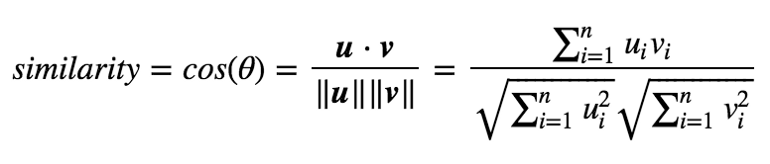

In [ ]:
# compute cosine similarity matrix
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [ ]:
df=df.reset_index() 

#create a reference table to extract movies based on index value 
indices = pd.Series(df.index, index=df['title'])

In [ ]:
def get_movie_recommendations(title, cosine_sim=cosine_sim):
    
    """
    This function accepts a movie title, cosine_similarity matrix and returns 10 similar movies as recommendation
    """
    
    title=title.lower()
    
    if title not in all_data['title'].str.lower().to_list():
        print (f'Sorry! {title.upper()} is not present in Netflix movie database')
        
    else:
        idx = indices[title]

        # Get the pairwsie similarity scores of all movies with that movie
        sim_scores = list(enumerate(cosine_sim[idx]))

        # Sort the movies based on the similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Get the scores of the 10 most similar movies
        sim_scores = sim_scores[1:11]

        # Get the movie indices
        movie_indices = [i[0] for i in sim_scores]

        # Return the top 10 most similar movies
        recommended_movies = all_data['title'].iloc[movie_indices]

        return print(f'Recommended movies based on your selection - {title.upper()}:\n', recommended_movies)

# Test the Model

Let's test the model with some movie names

In [ ]:
get_movie_recommendations('Die Another Day')

In [ ]:
get_movie_recommendations('The Conjuring')

In [ ]:
get_movie_recommendations('Lagaan')

In [ ]:
get_movie_recommendations('The Dark Knight')

# Conclusion

* This basic recommender system seems to be doing a decent job at recommending similar movies.
* There is a major drawback with this model which is it will not work with any movie title which is not present in the dataset or if the spelling does not match. 
* To overcome this issue, we can provide the users with a list of available titles to get the recommendations. 